# ISFS620 Data Science in Financial Services - Lab1

In [2]:
# import the relevant libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings

In [3]:
# if your version is below Colab's versions shown, and you refuse to upgrade, then consider using Colab
print(np.__version__) # 1.22.4
print(pd.__version__) # 1.5.3
print(sns.__version__) # 0.12.2
print(sm.__version__) # 0.13.5

1.21.5
1.4.4
0.11.2
0.13.2


Remember: the goal of the lab is to gain deep understanding.

You can import other libraries but importing libraries to automate tasks and not explaining the processes is insufficient to communicate your understanding.

## Question 1

### Pre-study

Just how good is the Augmented Dickey-Fuller test for stationarity?

*Lecture 2 analysis* has presented the code to generate synthetic data. Modify the code to generate data such that you know the ground truth and then apply the Augmented Dickey-Fuller test to inspect the results. Things you can try:

- Mean of series changes between periods (i.e., change can mean, gradual change or sharp change)
- Variance of the series changes between periods

You do not have to write any answer to this Pre-study section.

### Challenge

a) Demostrate how you would check whether the data is stationary or not.
   Use `# comments` to explain your processes.

b) If the data is not stationary, demonstrate how you would transform the data so it is weakly stationary.
Show the steps of your analysis clearly.


In [4]:
df_q1 = pd.read_excel('Lab1_AR_MA_ARIMA_Questions_v3.xlsx', sheet_name=0)
with pd.option_context('display.max_rows', 8):
    display(df_q1)

,dtm,x
0,2016-05-04,5.076535
1,2016-05-05,4.966607
2,2016-05-06,4.998279
3,2016-05-07,4.938702
...,...,...
450,2017-07-28,5.916089
451,2017-07-29,6.013131
452,2017-07-30,5.843730
453,2017-07-31,5.727024


In [5]:

df_q1.head()

,dtm,x
0,2016-05-04,5.076535
1,2016-05-05,4.966607
2,2016-05-06,4.998279
3,2016-05-07,4.938702
4,2016-05-08,4.993116


In [6]:
print ('Dickey-Fuller p-value = '+str(adfuller(df_q1['x'])[1]))

Dickey-Fuller p-value = 0.43302690222728785


In [13]:
df_q1["diff"] = df_q1["x"].diff()

In [14]:
print ('Dickey-Fuller p-value = '+str(adfuller(df_q1['diff'])[1]))

MissingDataError: exog contains inf or nans

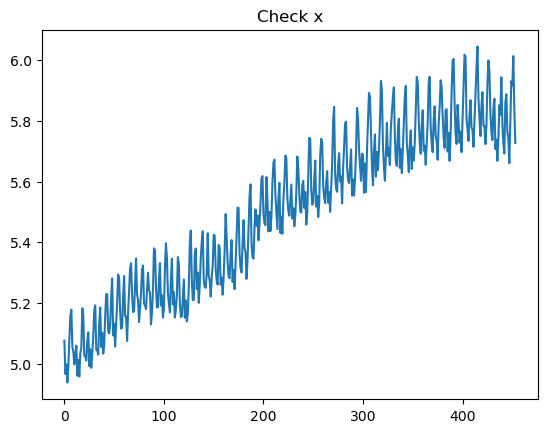

In [9]:
df_q1['x'].plot(title="Check x");

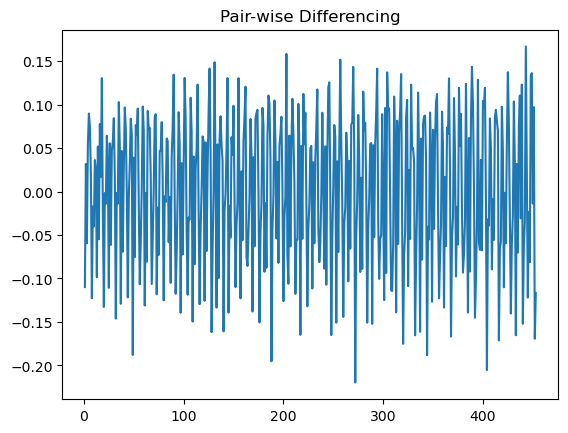

In [10]:
df_q1['diff'].plot(title="Pair-wise Differencing");

In [11]:
df_q1

,dtm,x,diff
0,2016-05-04,5.076535,NaN
1,2016-05-05,4.966607,-0.109929
2,2016-05-06,4.998279,0.031672
3,2016-05-07,4.938702,-0.059577
4,2016-05-08,4.993116,0.054414
...,...,...,...
449,2017-07-27,5.929855,0.136208
450,2017-07-28,5.916089,-0.013766
451,2017-07-29,6.013131,0.097042
452,2017-07-30,5.843730,-0.169401


In [12]:
# Converting the 'dtm' column to a datetime object
df_q1['dtm'] = pd.to_datetime(df_q1['dtm'])

# Computing the first differences of the data
diffs = np.diff(df_q1['x'])

# Adding the first difference as a new column 
df_q1['diffs'] = np.insert(diffs, 0, np.nan)

# Checking the differenced data is weakly stationary using the ADF test
result = adfuller(df_q1['diffs'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -5.177729
p-value: 0.000010
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


## Question 2
### Simple process simulation question to test conceptual application

*Lecture_2_analysis* notebook has shown you a way to generate time series MA processes using Python for-loop.

You can do better! Use the numpy library to generate the following time series MA process.

Based on what you have learnt from from Lecture_2_analysis, and only using the numpy library, create the following time series process.

#### MA(3)

$\mu=0$

$\theta_1 =0.4$

$\theta_2 =−0.3$ 

$\theta_3 =−0.5$

Afterwards, plot the ACF and PACF charts on the simulated time series data.

Bonus: challenge yourself to create a function that can take in a list of 𝜃 values.

In [117]:
def simulate_ma(theta, n = 1e8):
    # theta = a list of beta parameters, with theta[0] = 1, being the unit coefficient of e_t
    # n = number of data points, if your numpy implementation takes too long, you can lower this
    theta = np.array(theta)
    n = int(n)
    # replace the following statements with your code accordingly
    raise NotImplementedError
    fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
    _ = plot_acf(_, ax=ax1)
    _ = plot_pacf(_, method='ywm', ax=ax2)
    

In [ ]:
# test your function
simulate_ma([1, .4, -.3, -.5], n = 1e8)

## Question 3

### Pre-study

It is not often straightforward to deduce the ARMA parameters from observed messy real world data.

Build your intuition about how ACF and PACF charts will look like by generating synthetic data from known parameters. Things you can try:

- the error term has been modelled as standard White Gaussian noise, i.e., $e_{t} \sim N( 0,1)$.
<div style='margin-left:2.5em'>What if the error term is based on a different distribution, such as the uniform or beta distribution?</div>

- power terms in the lagging variables, e.g., $x_t = \beta_{1}x_{t-1}^2 + \theta_{1}e_{t-1}^3 + \theta_{2}e_{t-2}^2 + e_t$

- interaction terms in the lagging variables, e.g.,  $x_t = \beta_{1}x_{t-1}x_{t-3} + e_t$

You do not have to write any answer to this Pre-study section.

### The Challenge

For each of the following *stationary* datasets:
- `df_arma1`
- `df_arma2`

Plot the ACF and PACF charts and deduce the most likely *p* and *q* values from autoregression (A.R.) and moving average (M.A.) parameters that generate the time series data. You are not required to find the coefficients.

You may also use other diagnostic tools or techniques to help you find *p* and *q*.

In [122]:
df_arma1 = pd.read_excel('Lab1_AR_MA_ARIMA_Questions_v3.xlsx', sheet_name=1)
df_arma2 = pd.read_excel('Lab1_AR_MA_ARIMA_Questions_v3.xlsx', sheet_name=2)
with pd.option_context('display.max_rows', 8):
    display(df_arma1)
    display(df_arma2)

,arma1
0,1.455878
1,0.195994
2,-1.800859
3,0.833124
...,...
996,0.782980
997,-0.196168
998,-0.443949
999,-0.230902


,arma2
0,0.037861
1,1.056534
2,-1.419875
3,-1.392907
...,...
996,-1.417729
997,0.882754
998,0.029398
999,-0.395430


In [ ]:
# write your code here


In [ ]:
# what is p and q for df_arma1?

# what is p and q for df_arma2?


## Question 4

For this question, you will examine how effective it is to refer to information criteria from model fitting in choosing the correct model.

The provided data `df_arma3` is generated based on the ground truth of ARMA(*p* = 3, *q* = 2).

- Fit different combinations of *p* and *q* using the `statsmodels ARIMA` api to examine the AIC, BIC, HQIC and/or any other parameters of interest.

<div style='margin-left:2.5em'>Do the information criteria agree with one another? If not, how would you make your decision on which <i>p</i> and <i>q</i> to choose, assuming that you do not know the ground truth?</div>

- Which diagnostic value is more sensitive to over-fitting or under-fitting?

In [98]:
df_arma3 = pd.read_excel('Lab1_AR_MA_ARIMA_Questions_v3.xlsx', sheet_name=3)
with pd.option_context('display.max_rows', 8):
    display(df_arma3)

,arma3
0,0.015406
1,2.022143
2,1.607433
3,0.269528
...,...
996,-2.591944
997,-4.144650
998,-3.149170
999,-0.353954


In [ ]:
# write your code here
# use comments or markdown to describe your approach and findings


## Question 5

*Lecture 3* demonstrates how to perform Vector Autoregression (using the example of AAPL-MSFT).

A follow-up question is, out of the universe of potential securities, how do we choose the securities in a VAR model?

Let's make the problem more tractable by choosing a pair of securities in a VAR model and ignoring feature engineering for now.

Using BAC, BAK, AAPL, and MSFT, find the best *pair* of securities (e.g., AAPL-MSFT, AAPL-BAC, etc.) that will yield the lowest out-of-sample MSE.

Does the pearson correlation coefficient (by itself) provide guidance on the best pair to select?

In [ ]:
# download directly from yfinance
import yfinance as yf
tickers = ['BAC','BAK','MSFT','AAPL']
data = yf.download(tickers=tickers, start='2021-01-01', end ='2022-01-29')
data = data.drop(['Volume', 'Open', 'High', 'Low','Adj Close'], axis = 1)

In [ ]:
# or just read it from pickle
data = pd.read_pickle('isfs620_lab1_aapl_bac_bak_msft.zip')

In [ ]:
# consider the following train test split
d = '2021-12-30' # train data cut-off
train = data['Close'][:d]
test = data['Close'][d:]

In [ ]:
# write your code here
# use comments or markdown to describe your approach and findings


In [ ]:
# present your findings or summary in this cell


## Question 6 (Optional)

<p><div style='font-weight:lighter'>The following is a case study adapted from ISSS602 Spreadsheet Modelling for Decision Making.</div>
<div style='font-weight:lighter'>There are multiple approaches to address the case. For the purpose of this course, you should attempt to apply what you have learnt in this module to derive a solution.</div></p>

#### Data Center Assets
The CEO of SAM Bank, who recently hired you as his assistant, requested you to examine the bank's IT asset capacity and to prepare a simple analysis report on the strengths and weaknesses of its data center's assets.

After consulting the key senior IT staff, you are able to tabulate the bank's annual business volume and headcount for the last 10 years, and the corresponding IT asset holding quantities. Contingent to getting the projected business volume and organization size for the next five years, you think you can put up the bank's future IT asset capacity plan.

But before you start, you recall the following advice given you by others:

- Past forecasts and equipment acquisitions were very crude, though they were adequate then when the business was fast growing.
- Growth rate had slowed significantly and from hereon such rough planning may lead to buying equipment too early and even possible expensive over-purchase, or technology obsolescence mistakes.
- Productivity would continue to improve, but its change rate should saturate and tail off.

More complex tools are available to model systems and network performance, and to monitor actual metrics of individual equipment, such as utilization level, input/output rates and response times, to help determine when and how much additional capacities are needed. However, the CEO wants something simple that he can use to examine if new applications are sharing existing hardware and to project future IT capacity requirements for the next few years.



In [2]:
df_dca = pd.read_excel('Lab1_AR_MA_ARIMA_Questions_v3.xlsx', sheet_name=4, header=1)
with pd.option_context('display.max_rows', 15):
    display(df_dca)

,yr,cus_dep,employees,les,mrs,hes,ds,ns,racks,fs
0,2018,3.910,743,20.0,80.0,18.0,34.0,16.0,30.0,71.0
1,2019,5.060,911,26.0,105.0,18.0,44.0,20.0,40.0,90.0
2,2020,6.049,1016,31.0,125.0,20.0,58.0,25.0,50.0,90.0
3,2021,7.774,1205,40.0,170.0,20.0,75.0,30.0,60.0,160.0
4,2022,10.028,1504,50.0,200.0,40.0,95.0,40.0,80.0,160.0
5,2023,12.006,1645,55.0,250.0,40.0,120.0,45.0,100.0,180.0
6,2024,14.605,1897,60.0,300.0,60.0,150.0,55.0,110.0,180.0
7,2025,17.388,2070,65.0,350.0,60.0,250.0,60.0,120.0,200.0
8,2026,20.815,2248,75.0,400.0,90.0,270.0,65.0,130.0,200.0
9,2027,23.920,2320,95.0,450.0,110.0,300.0,80.0,140.0,250.0


The columns are

<table style='border-collapse:collapse'>
<tbody>
<tr>
<th>column_name</th>
<th>column description</th>
</tr>
<tr>
<td>yr</td>
<td>Year (yyyy)</td>
</tr>
<tr>
<td>cus_dep</td>
<td>Customer Deposit ($b)</td>
</tr>
<tr>
<td>employees</td>
<td>Total Employees (headcount)</td>
</tr>
<tr>
<td>les</td>
<td>Low-end Servers (BIPS)</td>
</tr>
<tr>
<td>mrs</td>
<td>Mid-range Servers (BIPS)</td>
</tr>
<tr>
<td>hes</td>
<td>High-end Servers (BIPS)</td>
</tr>
<tr>
<td>ds</td>
<td>Data Storage ('00GB)</td>
</tr>
<tr>
<td>ns</td>
<td>Network Switches ('00MBPS)</td>
</tr>
<tr>
<td>racks</td>
<td>Racks (RU)</td>
</tr>
<tr>
<td>fs</td>
<td>Floor Space ('0 sq m)</td>
</tr>
</tbody>
</table>

The missing value (NaN) cells are the goals for your time-series predictive modelling.


In [ ]:
# write your code here
# use comments or markdown to describe your approach
def ols(y,x, matrix_methods=True):
    x=sns.add_constant(x)
    x9=x.head(9)
    y9=y.head(9)
    if matrix_method:
        b=np.linalg.inv(x9.T @ x9)@(x9.T@ y9)
        predictions = x.iloc[9:] 

In [ ]:
# present your findings or summary in this cell
